In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lpt-1-dataset/LPT 1.xlsx
/kaggle/input/lpt-2-dataset/LPT 2.xlsx
/kaggle/input/dpt1-dataset/DPT1.xlsx


In [2]:
!pip install mpl-chord-diagram
!pip install eli5

  Preparing metadata (setup.py) ... done
  Created wheel for mpl-chord-diagram: filename=mpl_chord_diagram-0.4.1-py2.py3-none-any.whl size=16686 sha256=ee5c6970341a14b07434d4fc18fd2baaf72182b4d7d40cbb7b55b8eadc6e06fd
  Stored in directory: /root/.cache/pip/wheels/e3/63/c5/7c88ede73f3c7d4921eeb8f1d620a7c7311992c4a452442334
Successfully built mpl-chord-diagram


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
import eli5
from mpl_chord_diagram import chord_diagram
import re

2024-04-01 06:16:53.171764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 06:16:53.171930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 06:16:53.296235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.random.seed(45)

In [5]:
df = pd.read_excel("/kaggle/input/lpt-2-dataset/LPT 2.xlsx")

In [6]:
df.head()

PATIENT      DOSE  LOC  MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]  \
0  PT26.nii  0.826907    2                              2747.250   
1  PT21.nii  1.576662    1                             21956.625   
2  PT21.nii  1.126818    1                             20012.625   
3  PT21.nii  1.053983    1                             13773.375   
4  PT21.nii  0.707359    1                            223166.250   

   MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]  \
0                                             2970   
1                                            22950   
2                                            20493   
3                                            14148   
4                                           225531   

   MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]  \
0                                         110   
1                                         850   
2                                         759   
3                                         524   
4                                        8353   

   MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]  \
0                                1341.766827   
1                                7400.856511   
2                                5223.737232   
3                                3951.632361   
4                               54037.783110   

   MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]  \
0                                           0.488404   
1                                           0.337067   
2                                           0.261022   
3                                           0.286904   
4                                           0.242141   

   MORPHOLOGICAL_Compacity(IBSI:No)[]  \
0                           17.890291   
1                           28.997289   
2                           18.865483   
3                           18.035344   
4                           56.288253   

   MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]  ...  \
0                                 0.031536  ...   
1                                 0.019457  ...   
2                                 0.029906  ...   
3                                 0.031282  ...   
4                                 0.010023  ...   

   GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)  \
0                                      436.321429   
1                                    15962.068180   
2                                     5130.887401   
3                                     3002.301587   
4                                    12174.967480   

   GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)  \
0                                      1724.714286   
1                                     93870.818180   
2                                     96188.642860   
3                                     46386.428570   
4                                    846929.102700   

   GLSZM_GreyLevelNonUniformity(IBSI:JNSA)  \
0                                 4.142857   
1                                 4.818182   
2                                 8.857143   
3                                 7.857143   
4                                21.410959   

   GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)  \
0                                           0.591837   
1                                           0.438017   
2                                           0.632653   
3                                           0.561224   
4                                           0.146650   

   GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)  \
0                                2.142857   
1                                1.909091   
2                                2.285714   
3                                2.428571   
4                               19.246575   

   GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)  \
0                                          0.306122   
1                                          0.173554   
2                                          0.163265   
3                                          0.1

In [7]:
df.shape

(27, 128)

In [8]:
df.dtypes

PATIENT                                              object
DOSE                                                float64
LOC                                                   int64
MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]                float64
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]       int64
                                                     ...   
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    float64
GLSZM_ZonePercentage(IBSI:P30P)                     float64
GLSZM_GreyLevelVariance(IBSI:BYLV)                  float64
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   float64
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    float64
Length: 128, dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Columns: 128 entries, PATIENT to GLSZM_ZoneSizeEntropy(IBSI:GU8N)
dtypes: float64(111), int64(16), object(1)
memory usage: 27.1+ KB


In [10]:
df.isna().sum()

PATIENT                                             0
DOSE                                                0
LOC                                                 0
MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]                0
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]     0
                                                   ..
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    0
GLSZM_ZonePercentage(IBSI:P30P)                     0
GLSZM_GreyLevelVariance(IBSI:BYLV)                  0
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   0
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    0
Length: 128, dtype: int64

In [11]:
df.drop("PATIENT", axis = 1, inplace=True)

In [12]:
df.columns

Index(['DOSE', 'LOC', 'MORPHOLOGICAL_Volume(IBSI:RNU0)[mm3]',
       'MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]',
       'MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]',
       'MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]',
       'MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       ...
       'GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_ZonePercentage(IBSI:P30P)', 'GLSZM_GreyLevelVariance(IBSI:BYLV)',
       'GLSZM_ZoneSizeVariance(IBSI:3NSA)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)'],
      dtype='object', length=127)

<Axes: >

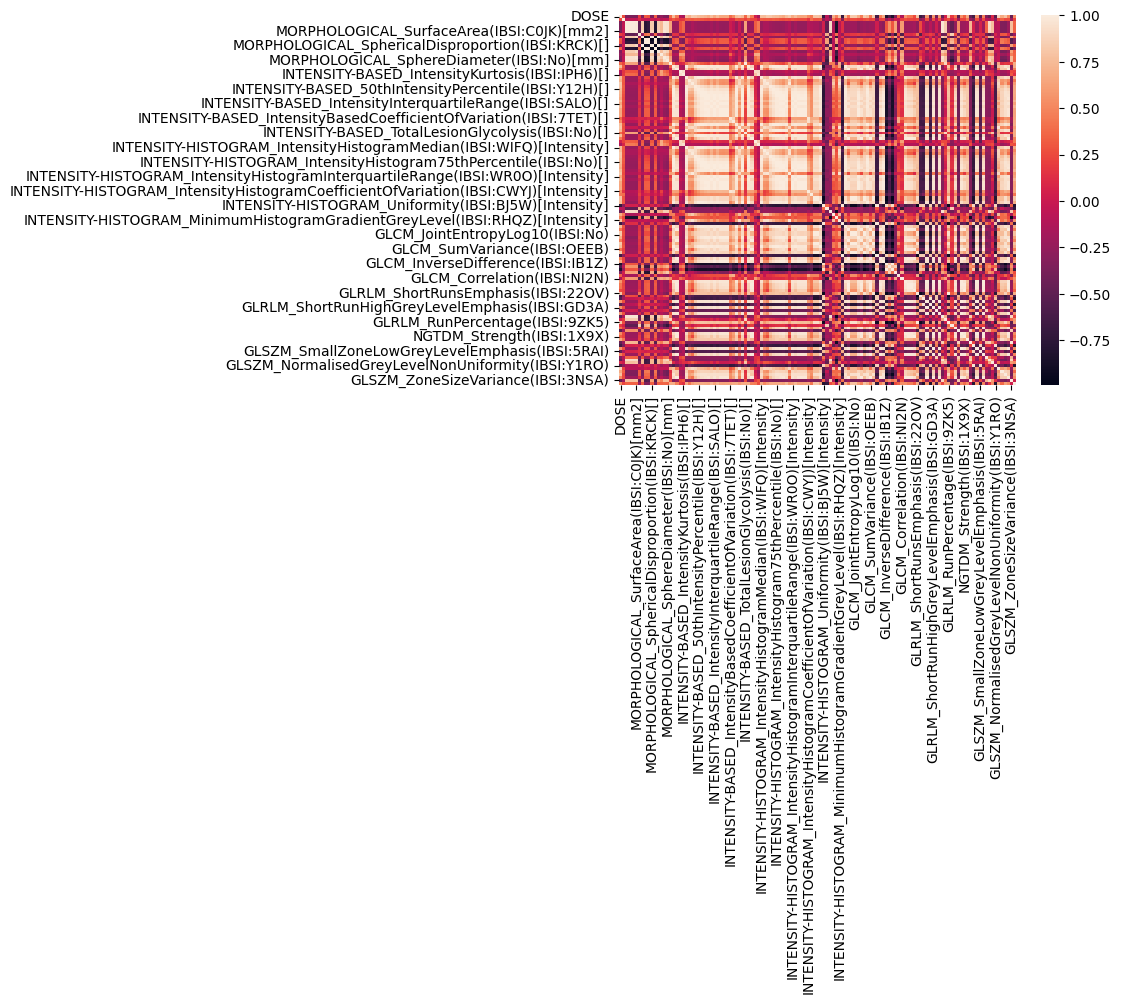

In [13]:
sns.heatmap(df.corr())

In [14]:
def calculate_scores(y, y_pred):
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    return r2, mae, mse

In [15]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [16]:
# This function evaluates the performance of a model over multiple iterations
# using bootstrapping and KFold cross-validation with 5 splits.

def evaluate_model(X, y, model, n_iterations=500, sample_size=0.6, print_results=True):
    r2_train_scores = []
    mae_train_scores = []
    mse_train_scores = []
    rmse_train_scores = []

    r2_test_scores = []
    mae_test_scores = []
    mse_test_scores = []
    rmse_test_scores = []
    
    # K-fold cross-validation with k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for i in range(n_iterations):
        
        # Bootstrap resampling of the data
        X_boot, y_boot = resample(X, y, replace=True, n_samples=int(sample_size * len(X)), random_state=16)
        
        r2_train_fold_scores = []
        mae_train_fold_scores = []
        mse_train_fold_scores = []
        
        r2_test_fold_scores = []
        mae_test_fold_scores = []
        mse_test_fold_scores = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(X_boot), 1):
            X_train, X_test = X_boot[train_index], X_boot[test_index]
            y_train, y_test = y_boot.iloc[train_index], y_boot.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calculate metrics
            r2_train, mae_train, mse_train = calculate_scores(y_train, y_train_pred)
            
            r2_test, mae_test, mse_test = calculate_scores(y_test, y_test_pred)
            
            # Append scores for this fold
            r2_train_fold_scores.append(r2_train)
            mae_train_fold_scores.append(mae_train)
            mse_train_fold_scores.append(mse_train)
            
            r2_test_fold_scores.append(r2_test)
            mae_test_fold_scores.append(mae_test)
            mse_test_fold_scores.append(mse_test)
            

        # Append mean scores for this iteration
        r2_train_scores.append(np.mean(r2_train_fold_scores))
        mae_train_scores.append(np.mean(mae_train_fold_scores))
        mse_train_scores.append(np.mean(mse_train_fold_scores))
        rmse_train_scores.append(np.sqrt(np.mean(mse_train_fold_scores)))
        
        r2_test_scores.append(np.mean(r2_test_fold_scores))
        mae_test_scores.append(np.mean(mae_test_fold_scores))
        mse_test_scores.append(np.mean(mse_test_fold_scores))
        rmse_test_scores.append(np.sqrt(np.mean(mse_test_fold_scores)))

    if (print_results):
        # Train scores
        print_scores('Train', r2_train_scores, mae_train_scores, mse_train_scores, rmse_train_scores)
        
        # Test scores
        print_scores('Test', r2_test_scores, mae_test_scores, mse_test_scores, rmse_test_scores)
    
    return np.mean(r2_test_scores), np.mean(mse_test_scores)

In [17]:
# This function evaluates the performance of a GradientBoostingRegressor model based on the number of selected features.
# It iterates over different numbers of selected features, starting from 8 down to 1.

def evaluate_based_on_feature_number(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:

def evaluate_based_on_feature_number2(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Plot R^2 Score
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Mean Squared Error (MSE)
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def one_hot_encoding(df, feature_name):
    if feature_name in df.columns:
        encoder = OneHotEncoder(sparse_output=False)
        encoded_data = encoder.fit_transform(df[[feature_name]])
        one_hot_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([feature_name]))
        df = pd.concat([df, one_hot_df], axis=1)
        df = df.drop(feature_name, axis=1)
    return df   

In [20]:
# For simpler visualization
def get_simple_feature_name(feature_names):
    simple_names = []
    for feature_name in feature_names:
        simple_name=feature_name
        pattern = r'\((.*)'
        match = re.search(pattern, feature_name)
        if match:
            simple_name = match.group(1)
            if simple_name in simple_names:
                last_underscore_index = feature_name.rfind('_')
                simple_name = feature_name[last_underscore_index:] if last_underscore_index != -1 else feature_name
        simple_names.append(simple_name)
    return simple_names

In [21]:
def hist_plot(df):
    df_renamed = df.copy()
    df_renamed.columns = get_simple_feature_name(df.columns)
    df_renamed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [22]:
def pair_plot(X, y):
    X_renamed = X.copy()
    X_renamed.columns = get_simple_feature_name(X.columns)
    y_df = y.to_frame().rename(columns={0: 'Dose'})
    df = pd.concat([X_renamed, y_df], axis=1)
    for i in range(0, len(df.columns), 5):
        sns.pairplot(data=df,
                     x_vars=df.columns[i:i+5],
                     y_vars=['DOSE'])

In [23]:
def plot_chord_diagram(X):
    fig, ax = plt.subplots(figsize=(12, 12))
    chord_diagram(X.corr(), names=get_simple_feature_name(X.columns), ax=ax, rotation=0, fontsize=8)
    plt.show()

In [24]:
y=df['DOSE']
X=df.drop('DOSE', axis=1)

In [25]:
X_scaled = StandardScaler().fit_transform(X)

Section 1: Three-Step Feature Selection using Lasso Regression, Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [26]:
# Step 1: Initial feature selection using Lasso regression
# Eliminating features with lasso coef of 0
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (0.025001)
2. Feature MORPHOLOGICAL_Compactness1(IBSI:SKGS)[] (0.000000)
3. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (0.000000)
4. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[] (0.000000)
5. Feature INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity] (0.000000)
6. Feature INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity] (-0.000000)
7. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity] (-0.000000)
8. Feature INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity] (0.032101)
9. Feature INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity] (0.099258)
10. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity] (-0.000000)
11. Feature GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO) (0.000000)
12. Feature GLCM_InverseVariance(IBSI:E8JP) (-0.000000)
13. Feature GLCM_Correlation(IBSI:NI2N) (0.000000)
14. Feature GLCM_ClusterP

In [27]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [28]:
X_selected = X[selected_features]

In [29]:
X_selected.columns

Index(['LOC', 'MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLCM_InverseVariance(IBSI:E8JP)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)', 'NGTDM_Bu

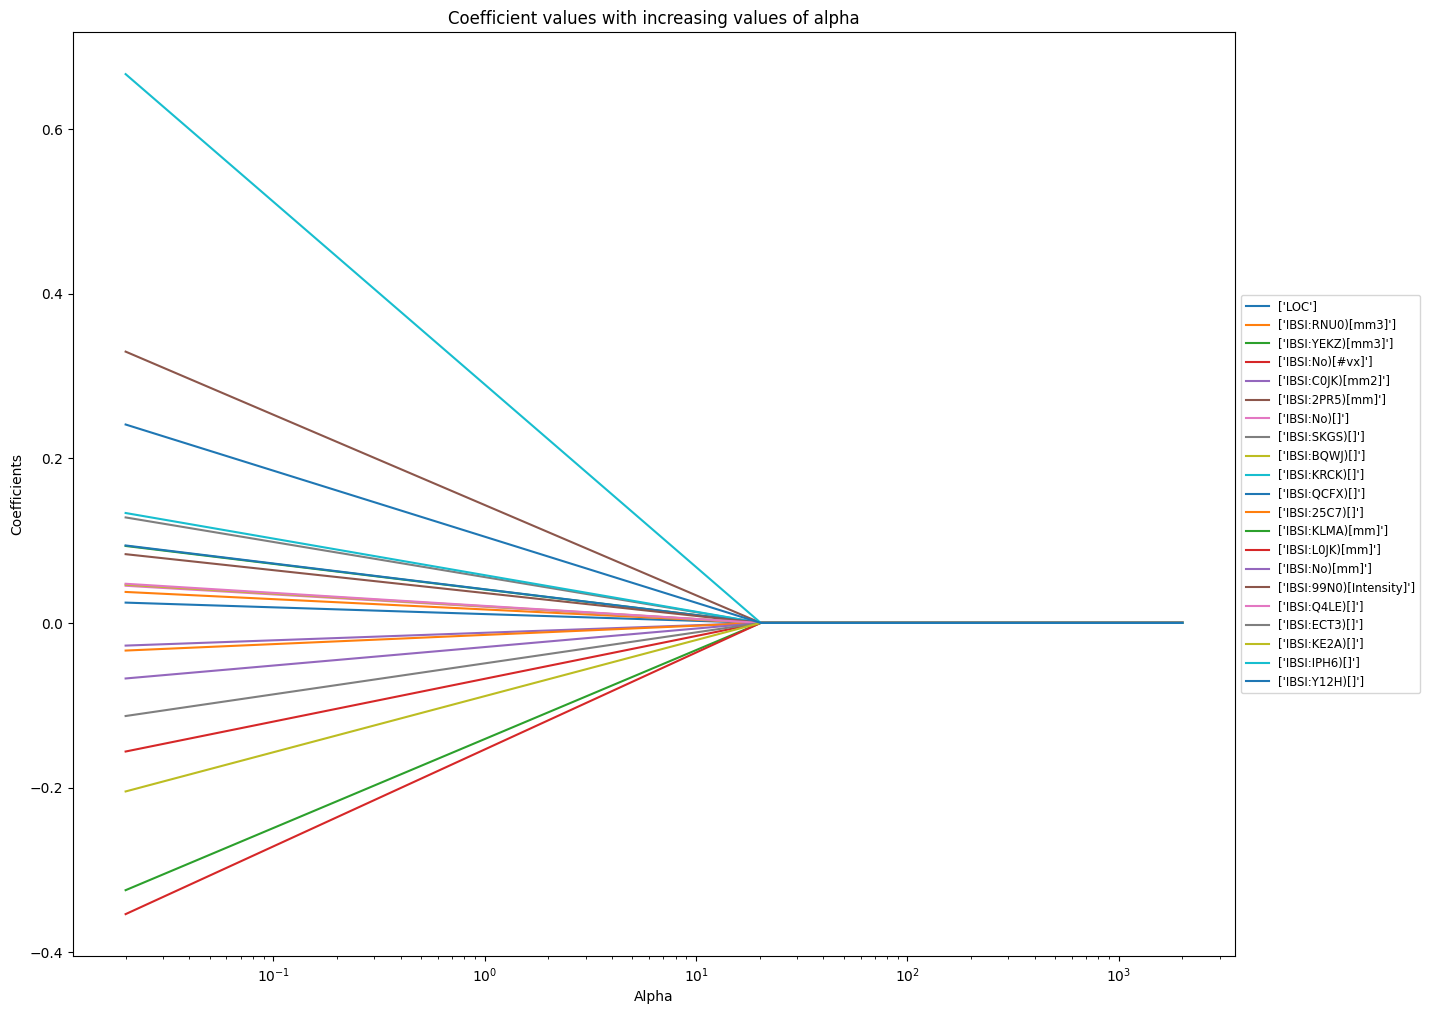

In [30]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

# Plot each feature's coefficient against alpha
ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()



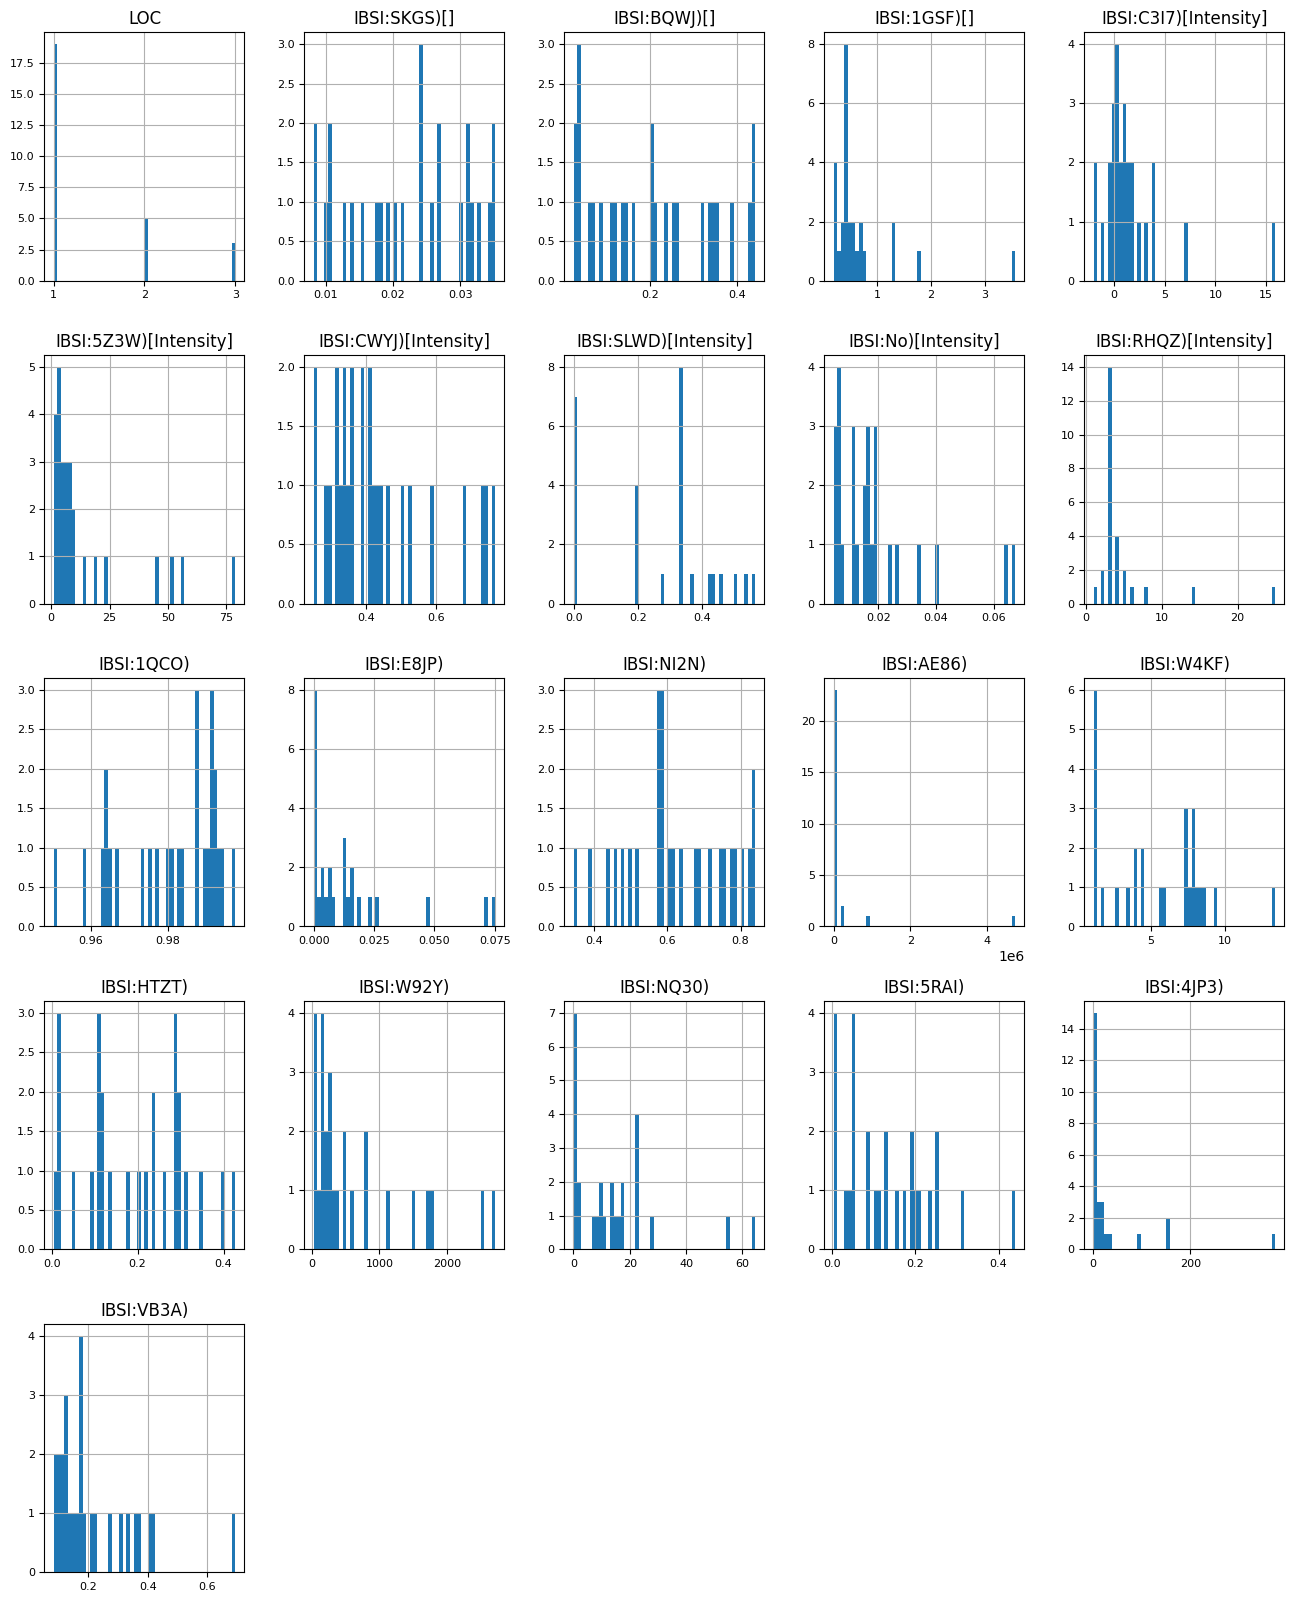

In [31]:
hist_plot(X_selected)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


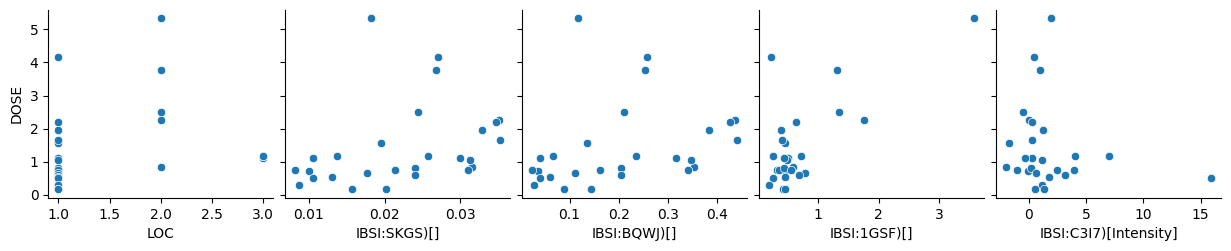

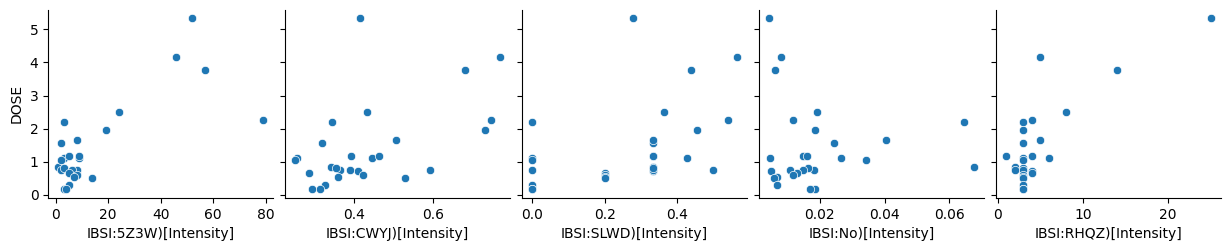

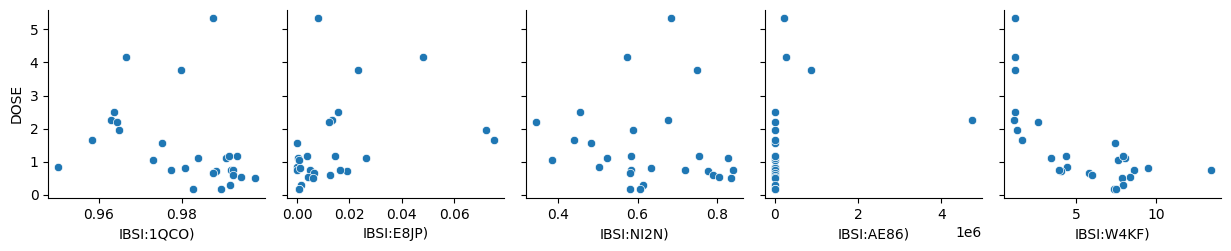

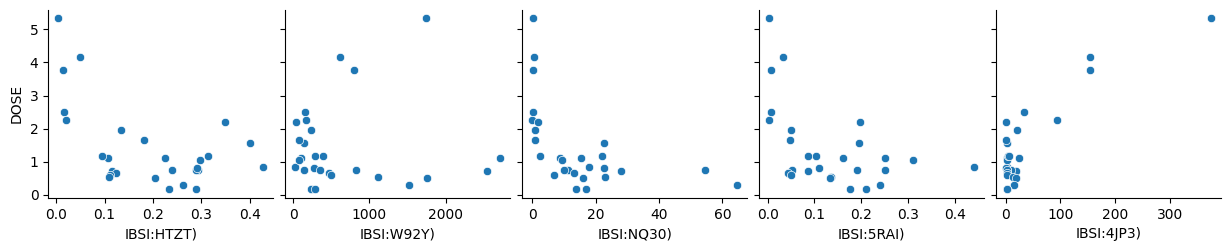

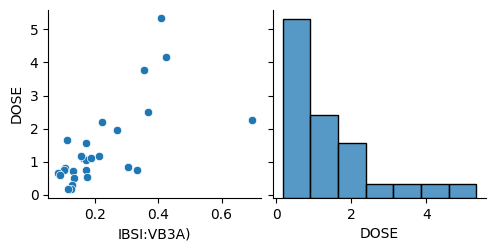

In [32]:
# Pair plots between the lasso selected features in X and the target variable DOSE.
pair_plot(X_selected, y)

In [33]:
# Encode LOC feature to one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [34]:
# Step 1 selected features
X_selected_encoded.columns

Index(['MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramKurtosis(IBSI:C3I7)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLCM_InverseVariance(IBSI:E8JP)', 'GLCM_Correlation(IBSI:NI2N)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)', 'NGTDM_Busyness(

In [35]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [36]:
# Evaluate the gradient boosting model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999986325042
Mean MAE: 4.558595406832051e-05
Mean MSE: 3.3630491155724054e-09
Mean RMSE: 5.799180214109927e-05


Mean Test Scores:
Mean R2 Score: 0.6837410232581631
Mean MAE: 0.24467145303433938
Mean MSE: 0.18239129677349683
Mean RMSE: 0.4270729408116332



Text(0.5, 1.0, 'Feature Importance ')

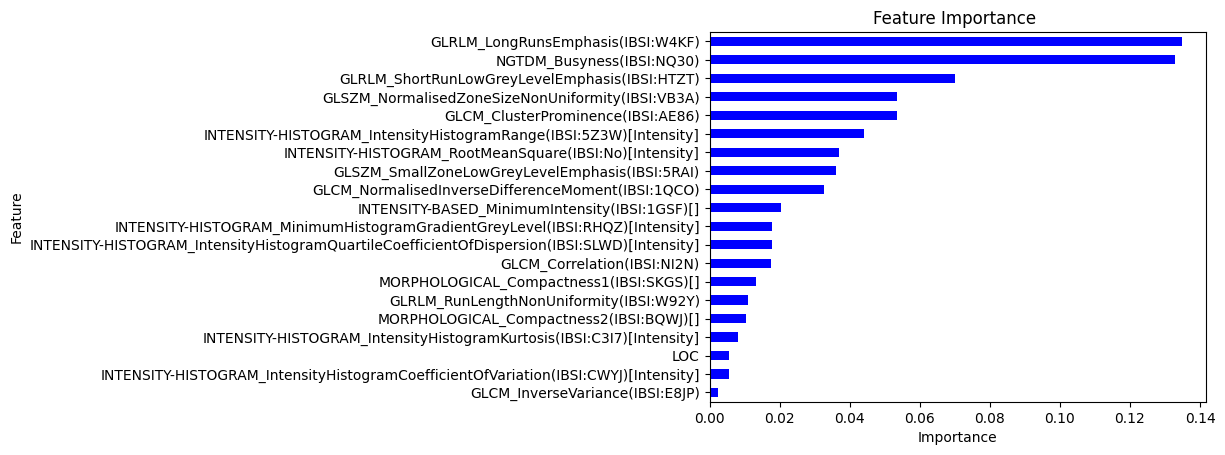

In [37]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from first step with rf feature importance > 0.01

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [38]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.276092)
2. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF) (0.134864)
3. Feature NGTDM_Busyness(IBSI:NQ30) (0.132819)
4. Feature GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT) (0.070068)
5. Feature GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A) (0.053568)
6. Feature GLCM_ClusterProminence(IBSI:AE86) (0.053463)
7. Feature INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity] (0.043960)
8. Feature INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity] (0.037041)
9. Feature GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI) (0.036055)
10. Feature GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO) (0.032512)
11. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[] (0.020292)
12. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity] (0.017936)
13. Feature INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity] (0.017917)
14. Feature GLCM_Correlation(IBSI:NI2N) (0.017536)

In [39]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [40]:
# Step 2 selected features
X_selected2.columns

Index(['MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)', 'NGTDM_Busyness(IBSI:NQ30)',
       'GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


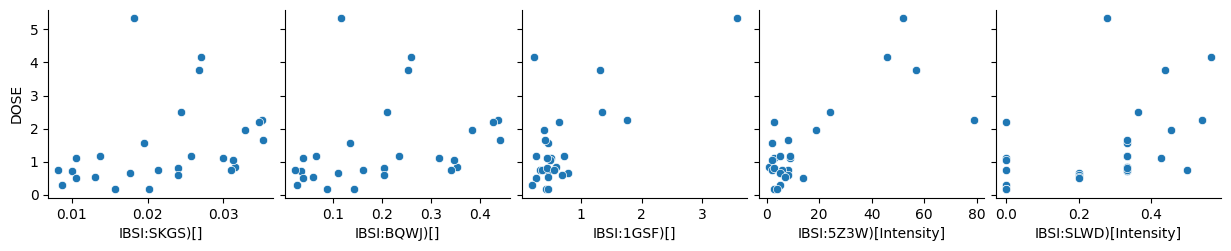

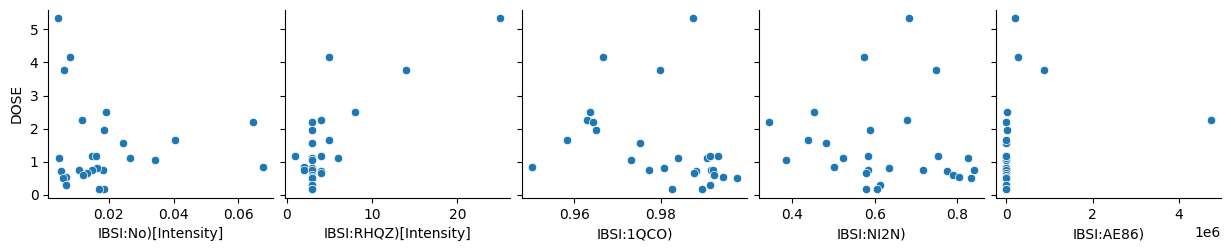

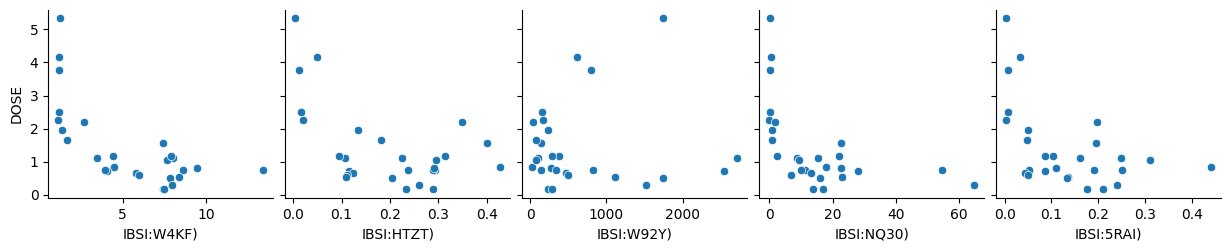

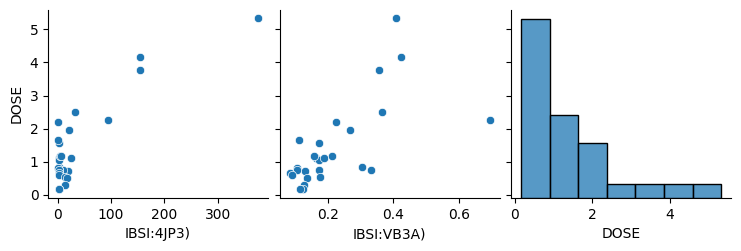

In [41]:
pair_plot(X_selected2, y)

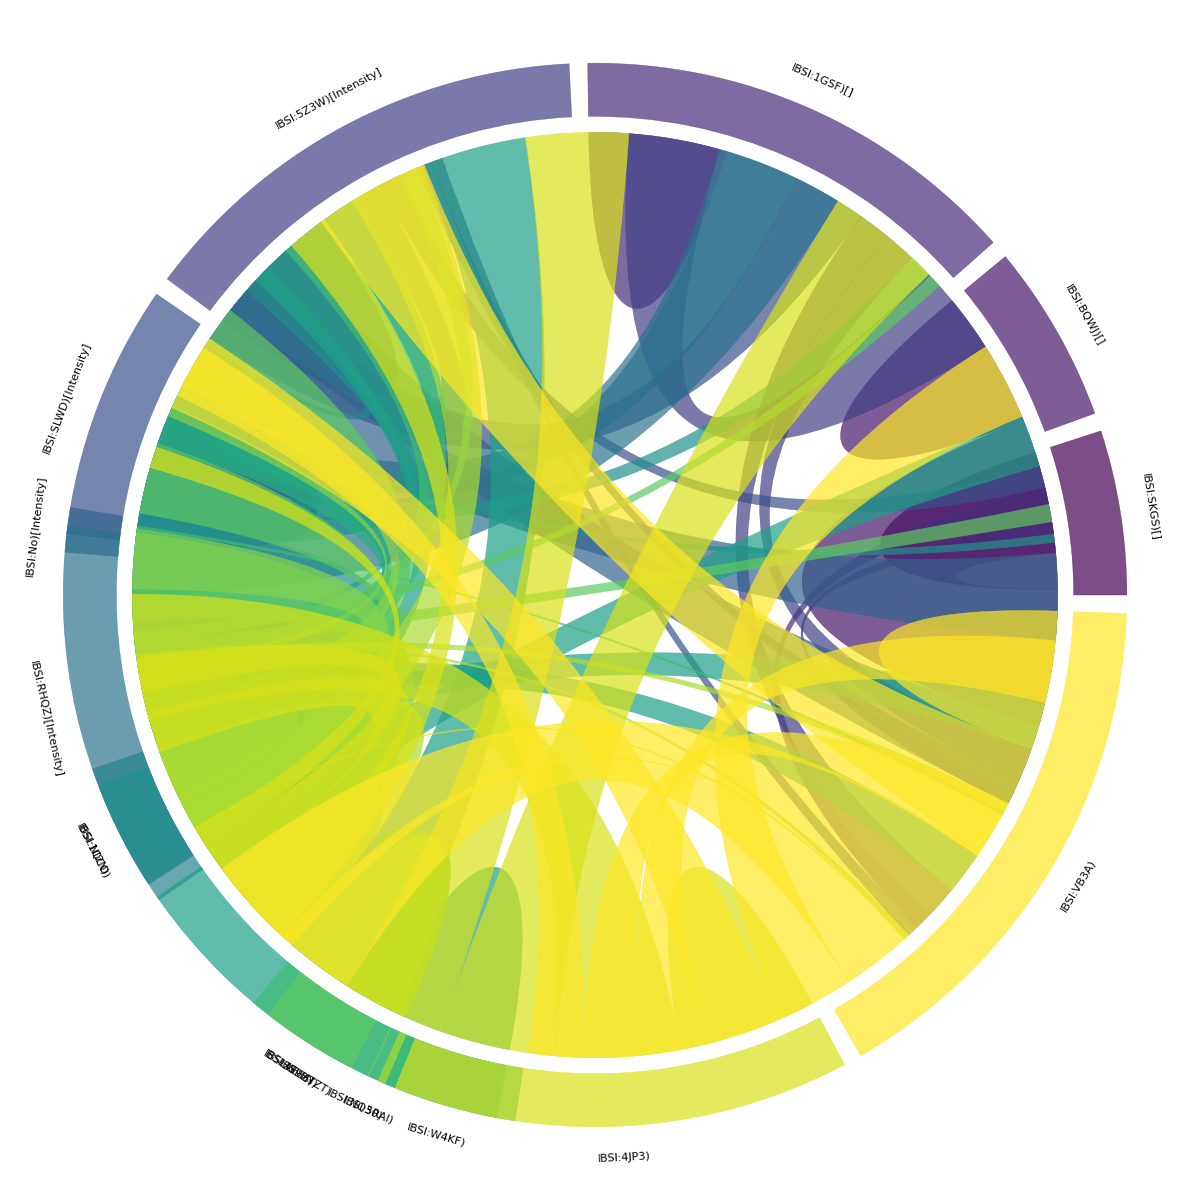

In [42]:
# Chord diagram for visualizing the correlation between selected features
plot_chord_diagram(X_selected2)

In [43]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [44]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [45]:
# Evaluate the gradient boosting model perfonmance on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999986005771
Mean MAE: 4.566374313855975e-05
Mean MSE: 3.4246382164422604e-09
Mean RMSE: 5.8520408546440116e-05


Mean Test Scores:
Mean R2 Score: 0.871687491956329
Mean MAE: 0.17850652020538643
Mean MSE: 0.1220411367083872
Mean RMSE: 0.3493438659950784



In [46]:
# Step 3: Recursive Feature Elimination (RFE) Using GradientBoostingRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]
2. Feature INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]
3. Feature GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)
4. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF)
5. Feature NGTDM_Busyness(IBSI:NQ30)
6. Feature GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI)
7. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)
8. Feature GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)


In [47]:
X_selected3 = X_selected2[selected_features]

In [48]:
X_selected3.shape

(27, 8)

In [49]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [50]:
X_selected3_sorted.shape

(27, 8)

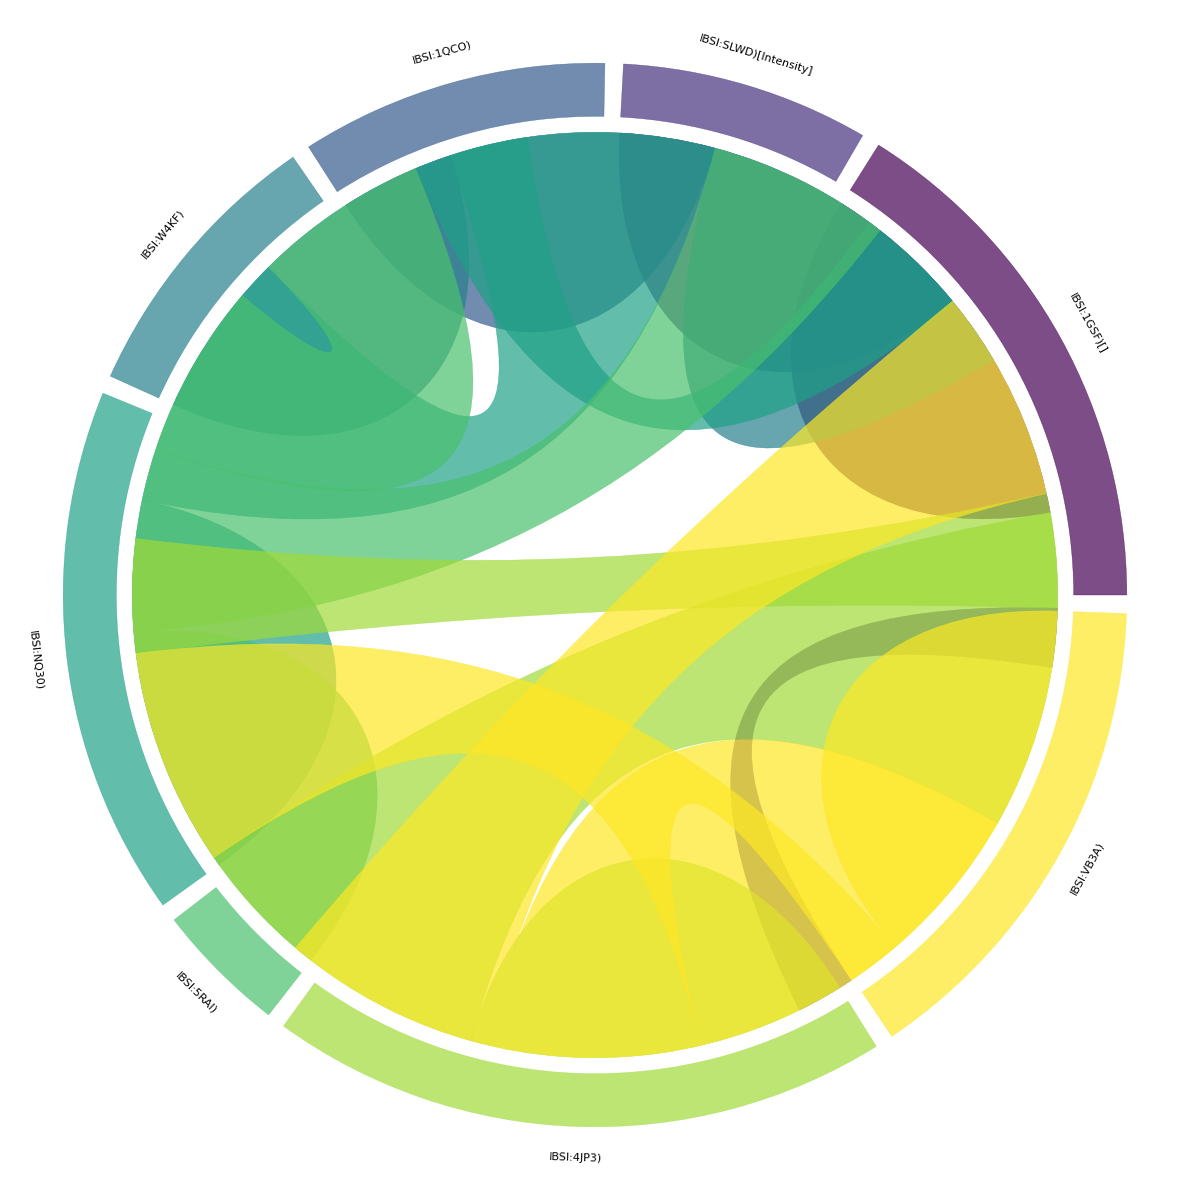

In [51]:
plot_chord_diagram(X_selected3)

In [52]:
# Final 8 selected features
X_selected3.columns

Index(['INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)', 'NGTDM_Busyness(IBSI:NQ30)',
       'GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)'],
      dtype='object')

In [53]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [54]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_selected3, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 21, Test set:6
Fold:2, Train set: 21, Test set:6
Fold:3, Train set: 22, Test set:5
Fold:4, Train set: 22, Test set:5
Fold:5, Train set: 22, Test set:5


In [56]:
# Final evaluation after 3 step feature selection using GradientBoostingRegressor as a model
# On final 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999978343598
Mean MAE: 5.754979203791696e-05
Mean MSE: 5.363712498170432e-09
Mean RMSE: 7.323737091246814e-05


Mean Test Scores:
Mean R2 Score: 0.8810295982833181
Mean MAE: 0.17303981478074643
Mean MSE: 0.10068468658022312
Mean RMSE: 0.3173085037943722



Section 2: One Step Feature Selection Using Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [59]:
# Recursive Feature Elimination (RFE) on the entire dataset
# Using GradientBoostingRegressor as the estimator and select 8 top features
estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_scaled, y)  
selected_features = X.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))

1. Feature INTENSITY-BASED_10thIntensityPercentile(IBSI:QG58)[]
2. Feature GLCM_JointMaximum(IBSI:GYBY)
3. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF)
4. Feature GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)
5. Feature GLSZM_GreyLevelNonUniformity(IBSI:JNSA)
6. Feature GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)
7. Feature GLSZM_ZonePercentage(IBSI:P30P)
8. Feature GLSZM_ZoneSizeEntropy(IBSI:GU8N)


In [60]:
X_selected = X[selected_features]

In [61]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected_sorted = X.iloc[:, sorted_selected_indices]

In [62]:
X_selected_sorted.shape

(27, 8)

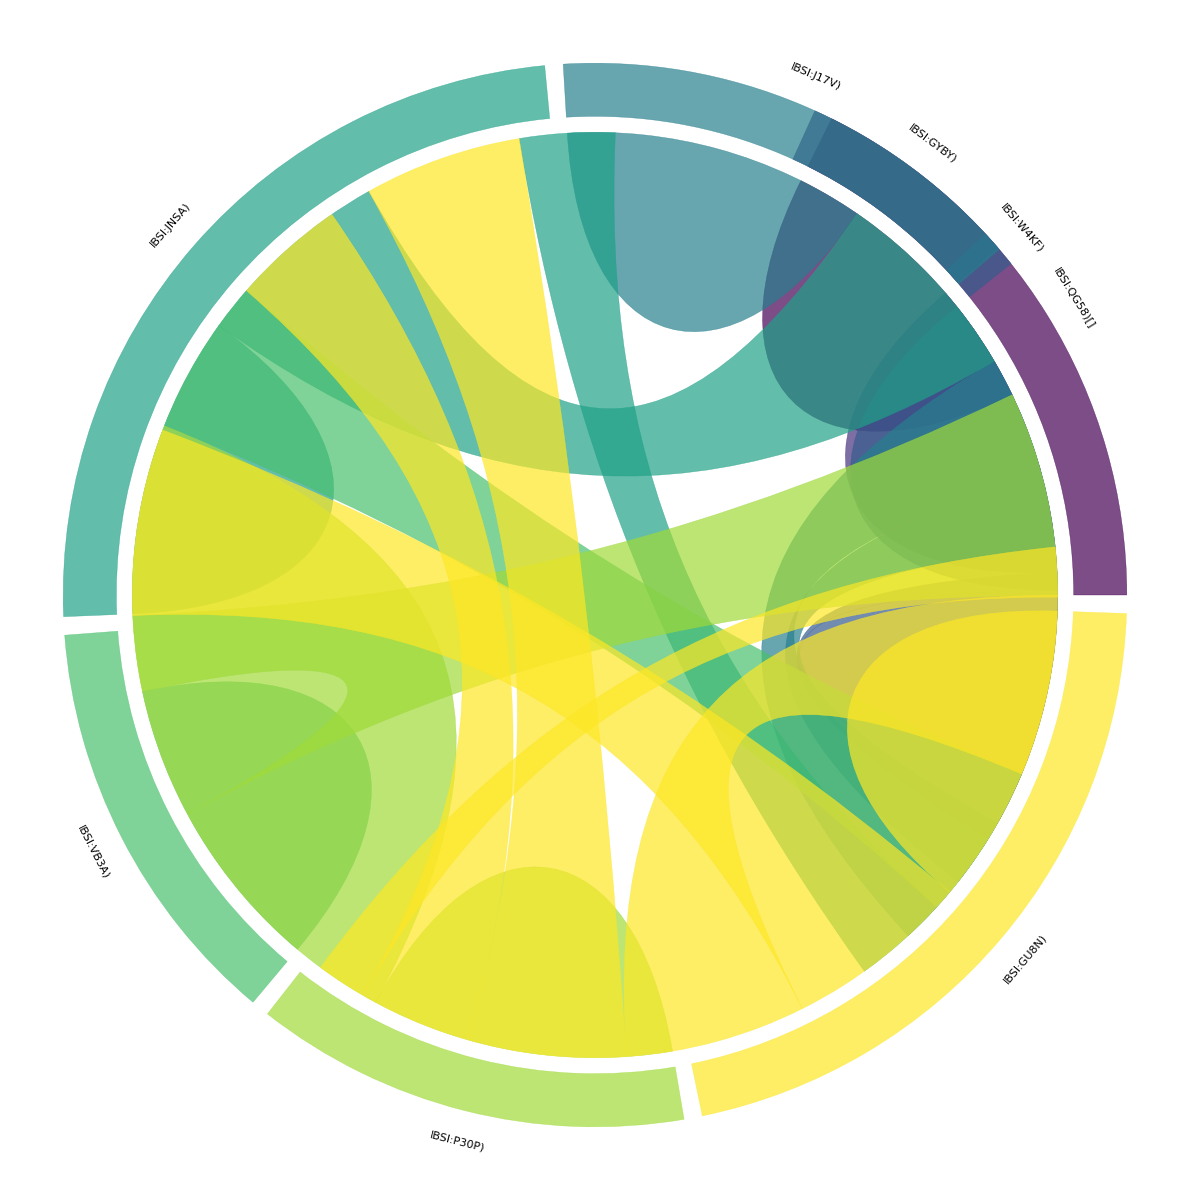

In [63]:
# Correlation between selected features
plot_chord_diagram(X_selected)

In [64]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_sorted)

In [65]:
# Evaluate the model perfonmance on 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999963538114
Mean MAE: 7.468950777008949e-05
Mean MSE: 9.177672481765603e-09
Mean RMSE: 9.580016952889805e-05


Mean Test Scores:
Mean R2 Score: 0.8557007335757151
Mean MAE: 0.22571032167110036
Mean MSE: 0.19774086047135875
Mean RMSE: 0.4446806274972621



Section 3: Three-Step Feature Selection using Lasso Regression (Starting from 50% feature removal), Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [68]:
# Step1: Remove 50% of features using lasso
lasso = Lasso(alpha=0.01, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]

feature_coefficients = pd.Series(lasso.coef_, index=X.columns)
sorted_coeffs = feature_coefficients.abs().sort_values(ascending=False)
num_features_to_keep = len(X.columns) // 2
selected_features = sorted_coeffs[:num_features_to_keep].index

for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.025001)
2. Feature GLCM_ClusterProminence(IBSI:AE86) (0.000000)
3. Feature INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity] (0.000000)
4. Feature GLCM_Correlation(IBSI:NI2N) (0.000000)
5. Feature GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A) (0.000000)
6. Feature GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI) (-0.000000)
7. Feature INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[] (-0.000000)
8. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity] (0.032101)
9. Feature INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity] (0.099258)
10. Feature NGTDM_Busyness(IBSI:NQ30) (-0.000000)
11. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (0.000000)
12. Feature GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO) (-0.000000)
13. Feature GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT) (0.000000)
14. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF) (-0.000000)
15. Featu

In [69]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [70]:
X_selected = X[selected_features]

In [71]:
# Step 1 selected features
X_selected.columns

Index(['GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity]',
       'GLCM_Correlation(IBSI:NI2N)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI)',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'NGTDM_Busyness(IBSI:NQ30)', 'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)

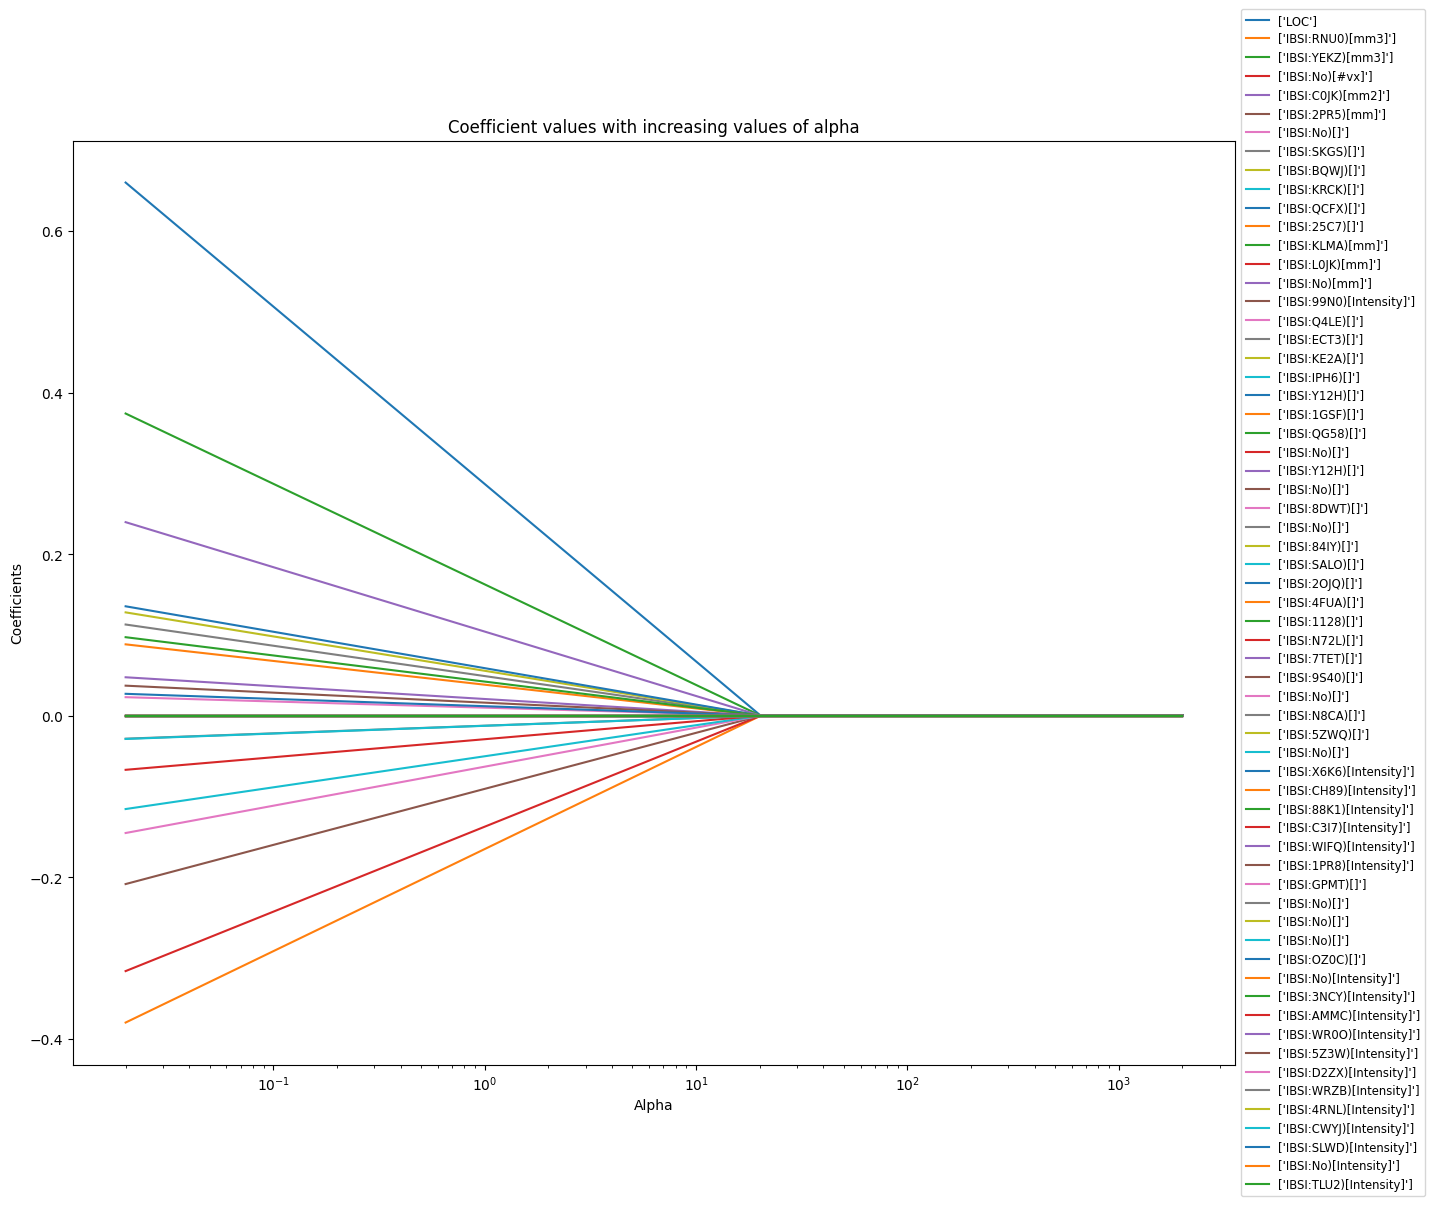

In [72]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()

In [73]:
# Encode the LOC feature using one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [74]:
X_selected_encoded.columns

Index(['GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'INTENSITY-HISTOGRAM_IntensityHistogramRange(IBSI:5Z3W)[Intensity]',
       'GLCM_Correlation(IBSI:NI2N)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_SmallZoneLowGreyLevelEmphasis(IBSI:5RAI)',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'NGTDM_Busyness(IBSI:NQ30)', 'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'GLCM_NormalisedInverseDifferenceMoment(IBSI:1QCO)',
       'GLRLM_ShortRunLowGreyLevelEmphasis(IBSI:HTZT)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'GLRLM_RunLengthNonUniformity(IBSI:W92Y)',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)

In [75]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [76]:
# Evaluate the model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.999999998564075
Mean MAE: 4.7109944584278056e-05
Mean MSE: 3.515700577585387e-09
Mean RMSE: 5.9293343450891584e-05


Mean Test Scores:
Mean R2 Score: 0.7659597898702863
Mean MAE: 0.22148381090829317
Mean MSE: 0.17312432324989363
Mean RMSE: 0.4160821111870752



Text(0.5, 1.0, 'Feature Importance ')

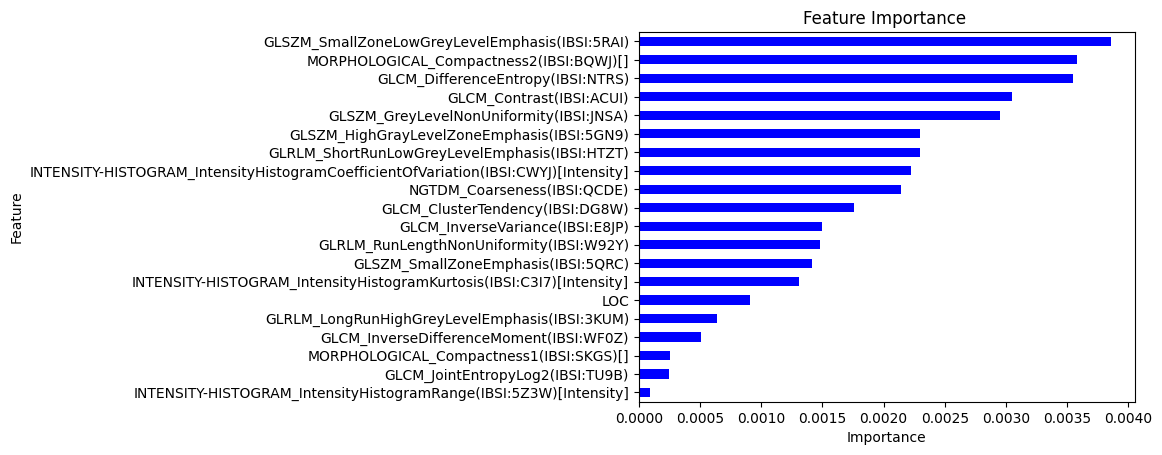

In [77]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from step 1 with rf feature importance > 0.01
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [78]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3) (0.166019)
2. Feature GLCM_JointMaximum(IBSI:GYBY) (0.080055)
3. Feature GLCM_AngularSecondMoment(IBSI:8ZQL) (0.062580)
4. Feature GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO) (0.045932)
5. Feature GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V) (0.038316)
6. Feature GLSZM_ZonePercentage(IBSI:P30P) (0.036099)
7. Feature GLRLM_GreyLevelNonUniformity(IBSI:R5YN) (0.034392)
8. Feature GLSZM_LargeZoneEmphasis(IBSI:48P8) (0.031100)
9. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF) (0.028306)
10. Feature GLCM_DifferenceAverage(IBSI:TF7R) (0.024919)
11. Feature NGTDM_Busyness(IBSI:NQ30) (0.023657)
12. Feature INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity] (0.023390)
13. Feature NGTDM_Contrast(IBSI:65HE) (0.023356)
14. Feature GLCM_DifferenceVariance(IBSI:D3YU) (0.019048)
15. Feature GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO) (0.018467)
16. Feature GLCM_ClusterShade(IBSI:7NFM) (0.018051)
17. Feature GLCM_ClusterPro

In [79]:
X_selected2 = X_selected.iloc[:, importances>0.01]

In [80]:
# Step 2 selected features
X_selected2.columns

Index(['GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'INTENSITY-BASED_MinimumIntensity(IBSI:1GSF)[]',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradientGreyLevel(IBSI:RHQZ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramQuartileCoefficientOfDispersion(IBSI:SLWD)[Intensity]',
       'NGTDM_Busyness(IBSI:NQ30)', 'GLRLM_LongRunsEmphasis(IBSI:W4KF)',
       'INTENSITY-HISTOGRAM_RootMeanSquare(IBSI:No)[Intensity]',
       'GLCM_JointMaximum(IBSI:GYBY)', 'GLCM_JointEntropyLog10(IBSI:No)',
       'GLCM_DifferenceAverage(IBSI:TF7R)',
       'GLCM_InverseDifference(IBSI:IB1Z)',
       'GLCM_DifferenceVariance(IBSI:D3YU)',
       'GLCM_AngularSecondMoment(IBSI:8ZQL)', 'GLCM_SumVariance(IBSI:OEEB)',
       'GLRLM_LowGreyLevelRunEmphasis(IBSI:V3SW)',
       'GLSZM_ZoneSizeVariance(IBSI:3NSA)', 'GLSZM_ZonePercentage(IBSI:P30P)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


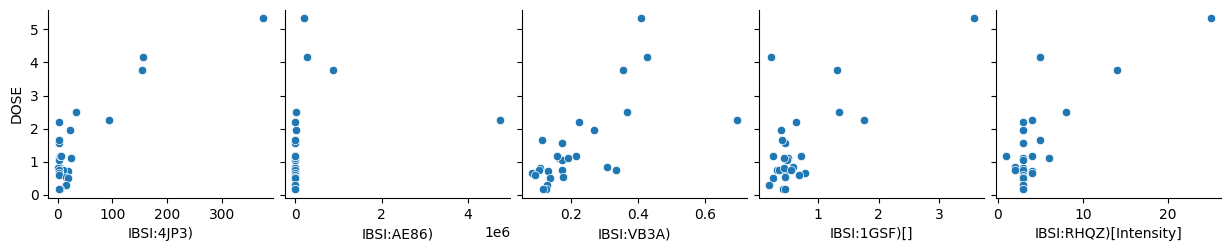

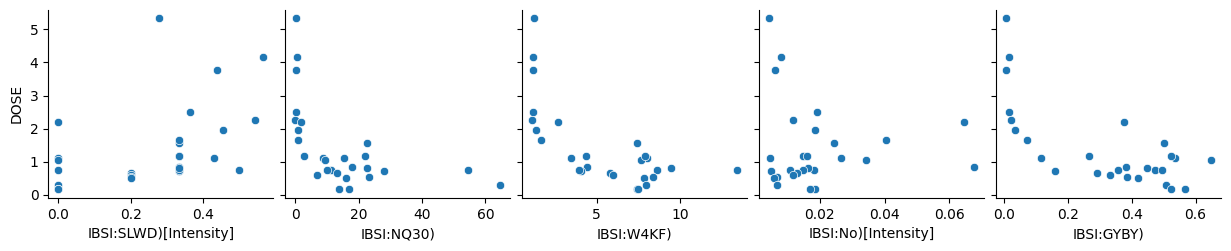

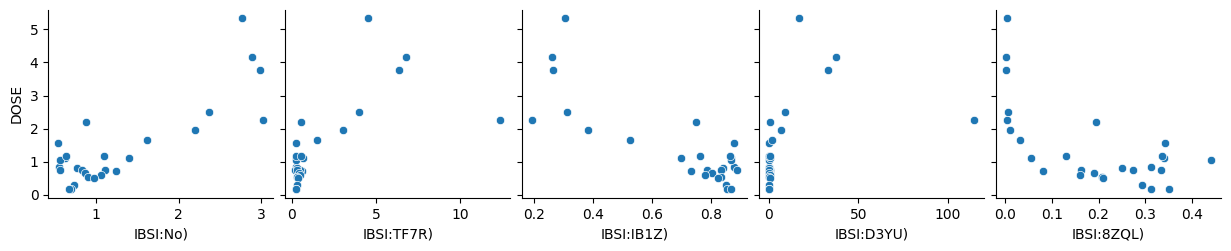

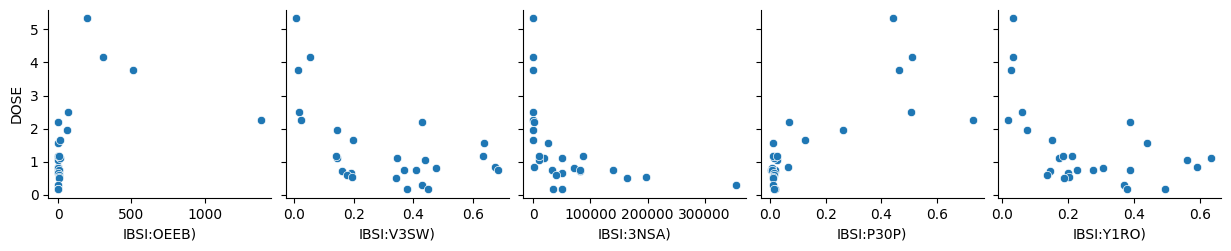

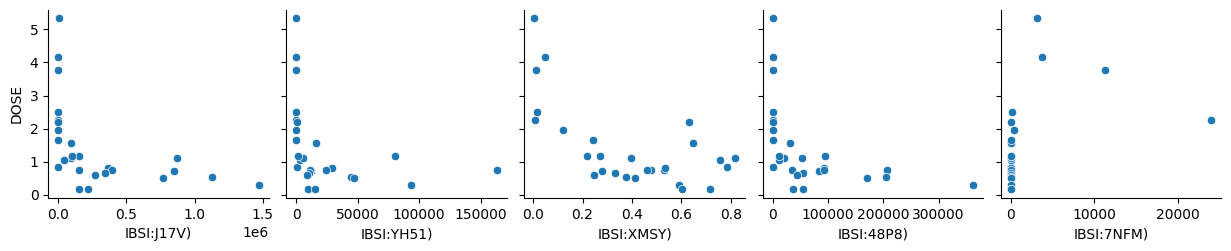

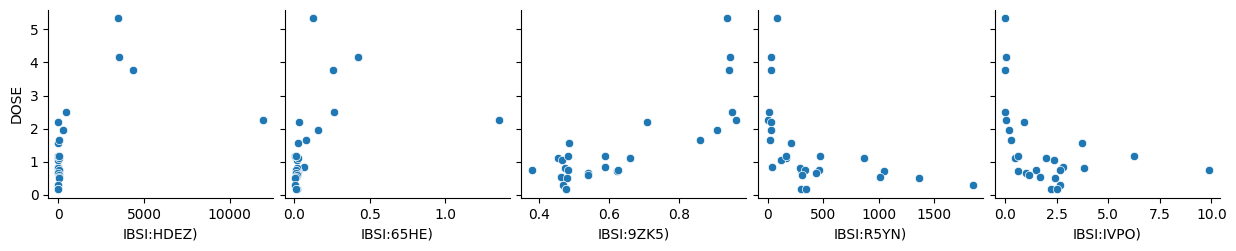

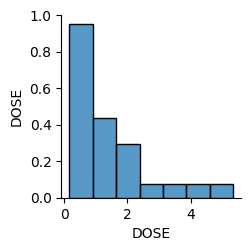

In [81]:
pair_plot(X_selected2, y)

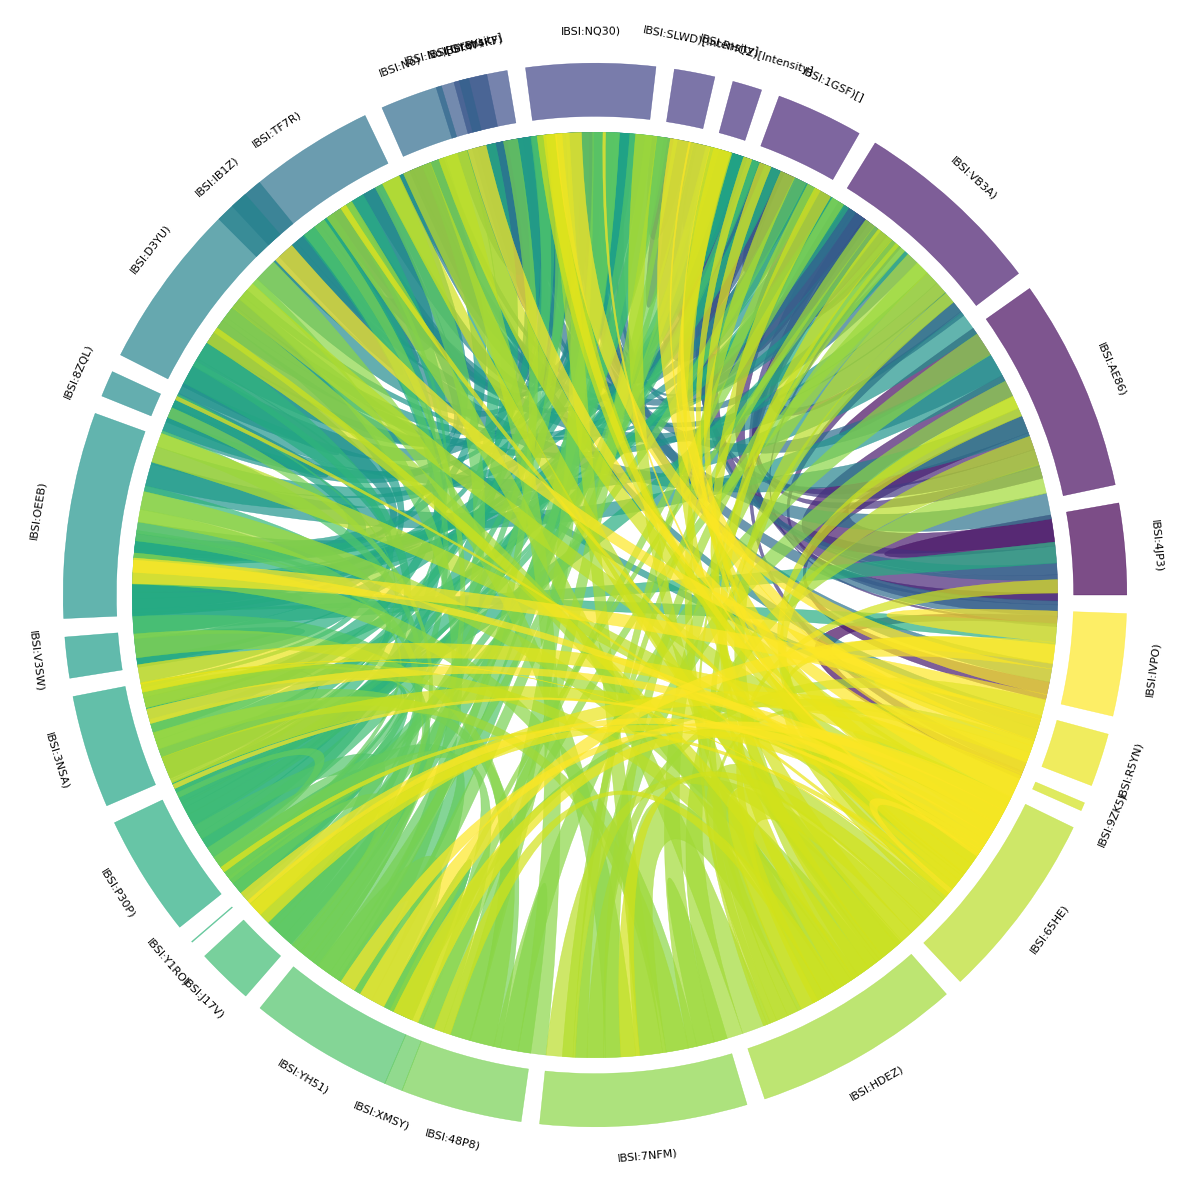

In [82]:
plot_chord_diagram(X_selected2)

In [83]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [84]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [85]:
# Evaluate model perfonmace on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999983140687
Mean MAE: 5.176000223030279e-05
Mean MSE: 4.149666811926938e-09
Mean RMSE: 6.441790754073698e-05


Mean Test Scores:
Mean R2 Score: 0.8802016828948601
Mean MAE: 0.17192577724784125
Mean MSE: 0.1207707796193223
Mean RMSE: 0.34752090529826024



In [86]:
# Step 3: Recursive Feature Elimination (RFE) Using GradientBoostingRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = GradientBoostingRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)
2. Feature GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)
3. Feature GLRLM_LongRunsEmphasis(IBSI:W4KF)
4. Feature GLCM_JointMaximum(IBSI:GYBY)
5. Feature GLSZM_ZonePercentage(IBSI:P30P)
6. Feature GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)
7. Feature GLSZM_LargeZoneEmphasis(IBSI:48P8)
8. Feature GLRLM_RunPercentage(IBSI:9ZK5)


In [87]:
X_selected3 = X_selected2[selected_features]

In [88]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [89]:
X_selected3_sorted.shape

(27, 8)

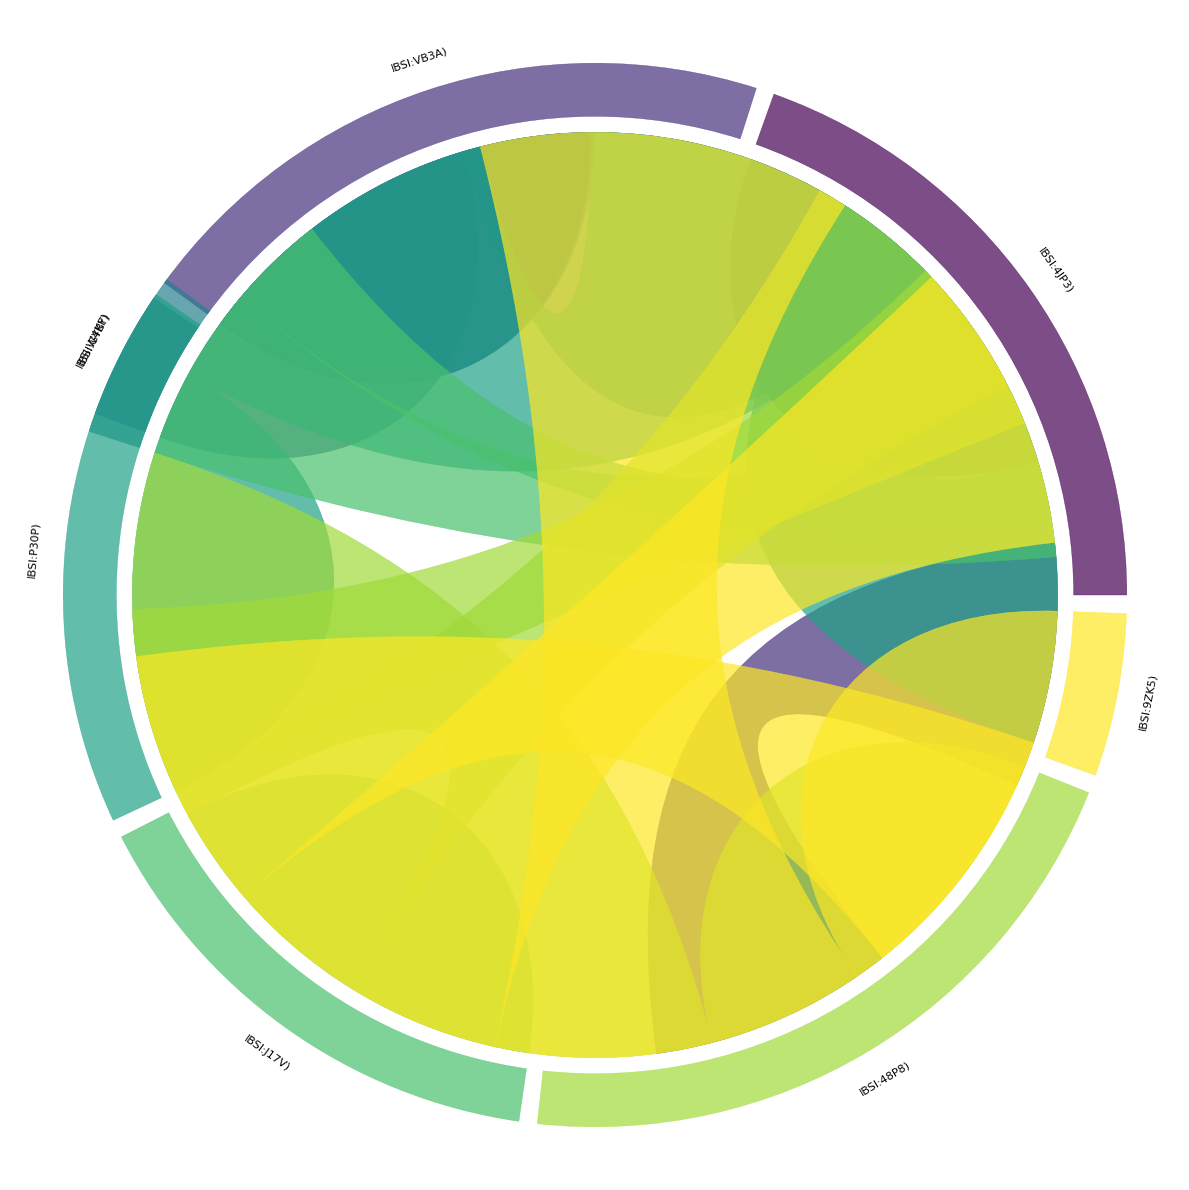

In [90]:
# Correlation plot of final selected features
plot_chord_diagram(X_selected3)

In [91]:
# Final 8 seleted features
X_selected3.columns

Index(['GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLRLM_LongRunsEmphasis(IBSI:W4KF)', 'GLCM_JointMaximum(IBSI:GYBY)',
       'GLSZM_ZonePercentage(IBSI:P30P)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLSZM_LargeZoneEmphasis(IBSI:48P8)', 'GLRLM_RunPercentage(IBSI:9ZK5)'],
      dtype='object')

In [92]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [93]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [94]:
# Evaluation on 8 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999980994071
Mean MAE: 5.214950579246791e-05
Mean MSE: 4.485623568738487e-09
Mean RMSE: 6.69747980119275e-05


Mean Test Scores:
Mean R2 Score: 0.9035189932997133
Mean MAE: 0.17450854268002655
Mean MSE: 0.14520301102540184
Mean RMSE: 0.3810551285908665

